In [1]:
from datetime import datetime, timedelta
from strategy.stratfact import StratFact
from backtester.backtester import Backtester
from processor.processor import Processor as p
from tqdm import tqdm
import pytz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

IndentationError: unexpected indent (competition.py, line 64)

In [ ]:
start = datetime(2018,1,1)
end = datetime(2021,1,1)
seats = 5

## Rolling Percent Backtest Testing

In [21]:
rp = StratFact.create_strat(start,end,"rolling_percent",modeling_params={"days":100,"currency":"prices"},
                        trading_params={"requirement":5,"value":
                                       True})
fp = StratFact.create_strat(start,end,"financial_predict",
                    modeling_params={"score_requirement":70,"categories":2,"model_training_year":4},
                    trading_params= {"requirement":10,"value":True})
pr = StratFact.create_strat(start,end,"progress_report",{},{"value":True,"requirement":5})
spec = StratFact.create_strat(start,end,"speculation",{
                    "number_of_training_weeks":14
                    ,"categories":2
                    ,"model_training_year":1
                    ,"score_requirement":70
                        },{
                    "score_requirement":70
                    ,"requirement":5
                    ,"value":True})
comp = StratFact.create_strat(start,end,"competition",modeling_params={
                    "categories":2
                    ,"model_training_year":1
                    ,"score_requirement":70
                        },
                        trading_params={
                    "score_requirement":70
                    ,"requirement":5
                    ,"value":True})
strats = {"rolling_percent":rp,"financial_predict":fp,"progress_report":pr,"speculation":spec,"competition":comp}

In [22]:
all_trades = []
for strat in tqdm(strats,desc="strategy_count"):
    strategy = strats[strat]
    strategy.subscribe()
    strategy.db.connect()
    sim = strategy.db.retrieve("sim")
#     for param in strategy.modeling_params:
#         sim = sim[sim[param]==strategy.modeling_params[param]]
    strategy.db.disconnect()
    sim = p.column_date_processing(sim)
#     print(strat,sim[sim["date"]>start].index.size)
    bt = Backtester(strategy)
    trades = bt.equity_timeseries_backtest(start,end,seats)
    t = pd.DataFrame(trades)
    t["strategy"] = strat
    all_trades.append(t)

strategy_count: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:55<00:00, 59.16s/it]


In [23]:
at = pd.concat(all_trades)
at["delta"] = (at["sell_price"] - at["adjclose"]) / at["adjclose"]

In [24]:
at

,date,adjclose,ticker,delta,seat,sell_price,sell_date,requirement,value,strategy,score_requirement
0,2018-01-02,26.475101,NWL,-0.206308,0,21.013085,2018-04-03,5,True,rolling_percent,NaN
1,2018-04-04,86.716634,ALB,0.050000,0,91.052466,2018-04-16,5,True,rolling_percent,NaN
2,2018-04-17,25.747864,BBWI,0.000000,0,25.747864,2018-06-04,5,True,rolling_percent,NaN
3,2018-06-05,29.410000,DISH,0.050000,0,30.880500,2018-06-06,5,True,rolling_percent,NaN
4,2018-06-07,17.722740,HWM,0.050000,0,18.608877,2018-07-16,5,True,rolling_percent,NaN
...,...,...,...,...,...,...,...,...,...,...,...
260,2020-10-21,211.380000,VRTX,0.000000,4,211.380000,2020-11-05,5,True,competition,70.0
261,2020-11-06,14.024226,NLSN,0.137586,4,15.953762,2020-11-16,5,True,competition,70.0
262,2020-11-17,13.212317,HBI,0.000000,4,13.212317,2020-12-02,5,True,competition,70.0
263,2020-12-03,16.363534,OXY,0.178906,4,19.291075,2020-12-09,5,True,competition,70.0


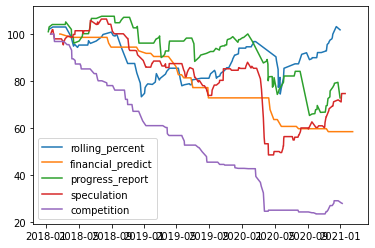

In [25]:
all_analysis = []
for strat in strats:
    strat_trades = at[at["strategy"]==strat]
    cash = []
    stuff = []
    total_cash = 100
    number_of_strats=1
    for seat in range(seats):
        initial = float(total_cash / number_of_strats / seats )
        seat_trades = strat_trades[strat_trades["seat"]==seat]
        for delta in seat_trades["delta"]:
            initial = initial * (1+delta)
            cash.append(initial)
    strat_trades["pv"] = cash
    stuff.append(strat_trades)
    analysis = pd.concat(stuff).pivot_table(index=["sell_date"],columns="seat",values="pv").fillna(method="ffill").fillna(float(total_cash / number_of_strats / seats )).reset_index()
    analysis["pv"] = [sum([row[1][i] for i in range(seats)]) for row in analysis.iterrows()]
    analysis["strategy"] = strat
    all_analysis.append(analysis)
    plt.plot(analysis["sell_date"],analysis["pv"])
plt.legend(strats.keys())
plt.show()

In [26]:
at

,date,adjclose,ticker,delta,seat,sell_price,sell_date,requirement,value,strategy,score_requirement
0,2018-01-02,26.475101,NWL,-0.206308,0,21.013085,2018-04-03,5,True,rolling_percent,NaN
1,2018-04-04,86.716634,ALB,0.050000,0,91.052466,2018-04-16,5,True,rolling_percent,NaN
2,2018-04-17,25.747864,BBWI,0.000000,0,25.747864,2018-06-04,5,True,rolling_percent,NaN
3,2018-06-05,29.410000,DISH,0.050000,0,30.880500,2018-06-06,5,True,rolling_percent,NaN
4,2018-06-07,17.722740,HWM,0.050000,0,18.608877,2018-07-16,5,True,rolling_percent,NaN
...,...,...,...,...,...,...,...,...,...,...,...
260,2020-10-21,211.380000,VRTX,0.000000,4,211.380000,2020-11-05,5,True,competition,70.0
261,2020-11-06,14.024226,NLSN,0.137586,4,15.953762,2020-11-16,5,True,competition,70.0
262,2020-11-17,13.212317,HBI,0.000000,4,13.212317,2020-12-02,5,True,competition,70.0
263,2020-12-03,16.363534,OXY,0.178906,4,19.291075,2020-12-09,5,True,competition,70.0


In [27]:
heh = pd.concat(all_analysis).sort_values("sell_date").pivot_table(index="sell_date",columns="strategy",values="pv")
heh.iloc[0] = heh.iloc[0].fillna(100)
heh.fillna(method="ffill")

strategy,competition,financial_predict,progress_report,rolling_percent,speculation
sell_date,,,,,
2018-01-08,100.00000,100.000000,101.000000,100.000000,100.000000
2018-01-10,100.00000,100.000000,102.000000,102.000000,100.000000
2018-01-11,100.00000,100.000000,103.000000,102.000000,100.000000
2018-01-17,100.00000,100.000000,103.000000,102.000000,100.000000
2018-01-19,100.00000,100.000000,103.000000,102.000000,100.000000
...,...,...,...,...,...
2021-01-08,28.10327,58.560302,72.895765,101.790403,74.740186
2021-01-19,28.10327,58.560302,72.895765,101.790403,74.740186
2021-02-01,28.10327,58.560302,72.895765,101.790403,74.740186


In [28]:
at[at["strategy"]=="rolling_percent"]

,date,adjclose,ticker,delta,seat,sell_price,sell_date,requirement,value,strategy,score_requirement
0,2018-01-02,26.475101,NWL,-0.206308,0,21.013085,2018-04-03,5,True,rolling_percent,NaN
1,2018-04-04,86.716634,ALB,0.050000,0,91.052466,2018-04-16,5,True,rolling_percent,NaN
2,2018-04-17,25.747864,BBWI,0.000000,0,25.747864,2018-06-04,5,True,rolling_percent,NaN
3,2018-06-05,29.410000,DISH,0.050000,0,30.880500,2018-06-06,5,True,rolling_percent,NaN
4,2018-06-07,17.722740,HWM,0.050000,0,18.608877,2018-07-16,5,True,rolling_percent,NaN
...,...,...,...,...,...,...,...,...,...,...,...
148,2020-09-09,55.127718,PSX,0.000000,4,55.127718,2020-11-10,5,True,rolling_percent,NaN
149,2020-11-11,47.157494,EBAY,0.050000,4,49.515369,2020-11-24,5,True,rolling_percent,NaN
150,2020-11-25,25.707718,FE,0.050000,4,26.993104,2020-12-03,5,True,rolling_percent,NaN
151,2020-12-04,83.140000,INCY,0.050000,4,87.297000,2020-12-17,5,True,rolling_percent,NaN
